In [1]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Kalman Filter

- Simulate the trajectory of a ball with the parameters launch position (especially the height
above an imaginary ground), launch speed and launch angle of the ball.
- Simulate the observation of the ball position (x, y as shown in the slides). The estimated
ball position shall be subject to uncertainty and it shall be possible to parameterize this
uncertainty. In addition, the time span between two observations shall be variable and the
observations shall be able to drop out completely over a certain period of time.
- The initial parameters of the Kalman Filter shall be adaptable.
- The normally distributed noise on transition and observation should be adjustable. This means
that the covariance matrices R and Q shall be set as a parameter in the Kalman Filter.

#### Sources 

https://thekalmanfilter.com/kalman-filter-explained-simply/         

https://machinelearningspace.com/object-tracking-python/

https://youtu.be/m5Bw1m8jJuY

400 - Context Classification slides

In [2]:
# Gravity on the different planets and the moon
# Source is NASA

SUN = 275.0
MERCURY = 3.7
VENUS = 8.87
EARTH = 9.81
MOON = 1.6
MARS = 3.7
JUPITER = 23.1
SATURN = 9.0
URANUS = 8.7
NEPTUNE = 11.0
PLUTO = 0.7

In [3]:
def trajectory(v0, y0, angle, dt, delta_time, g):
    '''
    v0 = initial velocity
    y0 = initial height 
    angle = angle of launch (expected in degrees)
    dt  = time step size 
    delta_time = total time spent 
    g = gravity
    '''
    angle = np.deg2rad(angle) # changing the angle to radians 
    x0 = 0 # initializing the x position as 0 

    samples = int(delta_time/dt) # how many samples there will be
    total_time = np.linspace(0, delta_time, samples) # evenly spaced interval
    vx0 = np.cos(angle)*v0 # initial velocity in x directions
    vy0 = np.sin(angle)*v0 # initial veolcity in y direction
    
    x = x0 + (vx0 * total_time) # position of ball in the x directions
    y = y0 + (vy0 * total_time) - (0.5 * g * (total_time**2)) # position of ball in y direction
    vx = np.repeat(vx0, samples) # goes through vx0 sample amount of times
    vy = vy0-g*total_time # velocity in y direction during flight
    
    q = np.stack((x, y, vx, vy)) # the state signal 
    
    return(q, total_time)

In [4]:
def noise(q, mean, std):
    '''
    q = signal state
    mean = mean 
    std = standard deviation (for Gaussian that would be the covariance matrix)
    '''
    noise = np.random.multivariate_normal(mean, std, q.shape[1]).T
    q_noise = q + noise 
    
    return q_noise

In [5]:
def dropout(q, t0, time_spent, dt, error_val):
    start = int(t0/dt) - 1
    end = start + int(time_spent/dt) + 1

    q_dropout = q.copy()
    q_dropout[1, start:end] = error_val
    return q_dropout

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


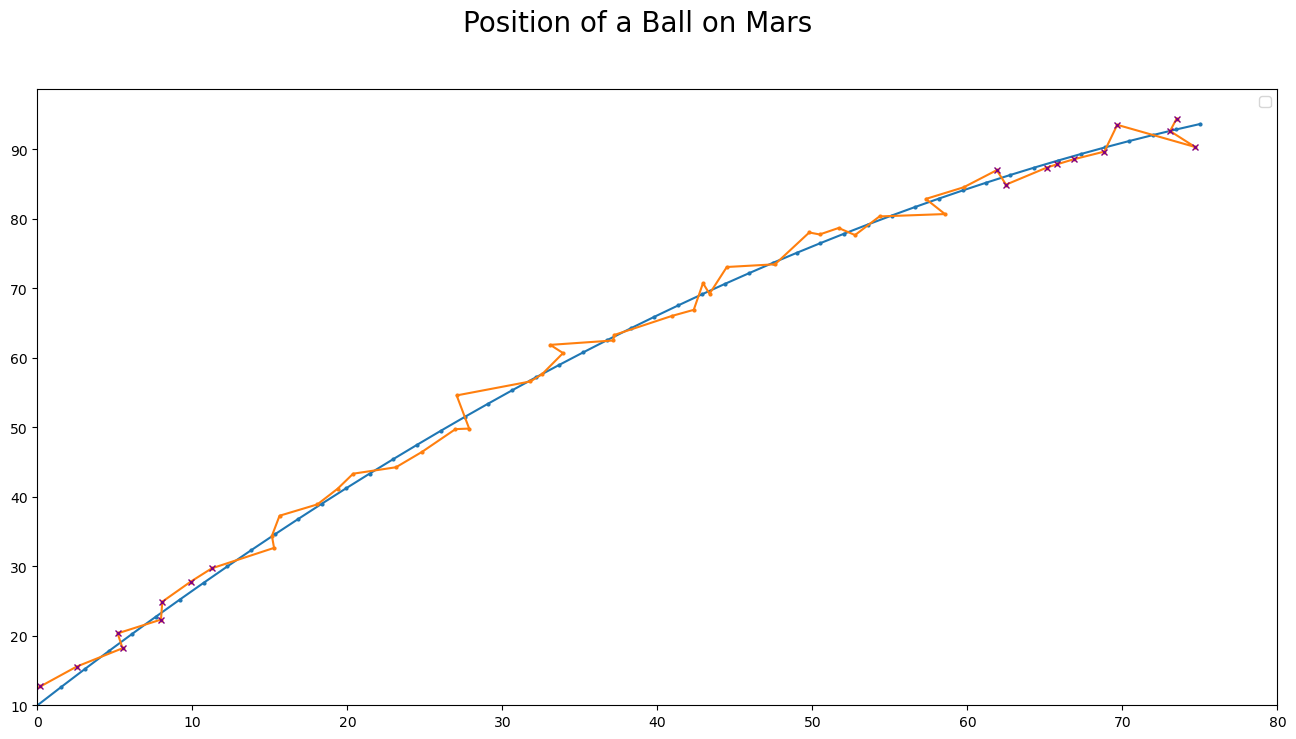

In [6]:
mean_noise = [0, 0]
cov_noise = np.eye(2)
dt = 0.1
planet = "Mars"
g = MARS
ANGLE = 60

q_new, time = trajectory(v0=30, y0=10, angle=ANGLE, dt=dt, delta_time=5, g=g)
q = q_new[[0, 1]]

q_noise = noise(q, mean_noise, cov_noise)

q_dropout = dropout(q=q_noise, t0=1, time_spent=3, dt=0.1, error_val=-1000)

fig = plt.figure(figsize=(16,8))
fig.suptitle(f'Position of a Ball on {planet}', fontsize=20)
plt.plot(q[0], q[1], 'o', ls = '-', markersize=2)
plt.plot(q_noise[0], q_noise[1], 'o', ls = '-', markersize=2)
plt.plot(q_dropout[0], q_dropout[1], 'x', markersize=4, color='purple')
xmin = min(q[0])
xmax = max(q[0] + 5)
ymin = min(q[1])
ymax = max(q[1]+5)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend()
plt.show()

In [7]:
class KalmanFilter(object):
    # initialize class, giving it initial loacation and speed estimation of state variable 
    def __init__(self, dt, g, initial_mu = np.matrix([0, 0, 0, 0]).T, Q = np.eye(4), R = np.eye(2)):
        
        self.dt = dt

        self.g = MARS

        self.mu = initial_mu

        # state transition matrix
        self.A = np.matrix([[1,0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
        
        # control input matrix
        self.B = np.matrix([[0, 0, 0],
                            [0, (0.5 * (self.dt**2)), 0],
                            [0, 0, 0],
                            [0, self.dt, 0]])
        
        # constant acceleration due to gravity
        self.a = np.matrix([0, -self.g, 0]).T

        # Initial covariance matrix with the same size as matrix A
        self.E = np.eye(self.A.shape[1])

        # Noise Covariance process
        self.Q = Q

        # Noise Covariance measurement
        self.R = R

        # Transfomation matrix
        self.C = np.matrix([[1, 0, 0, 0],
                            [0, 1, 0, 0 ]])
        
    
    def predict(self):
        '''
        Equation 1 and 2 from the slides:
            mu_prime = A * mu0 + B*a0
            E_prime = A * E0 * A_transpose + Q
        '''
        # a priori state estimate
        self.mu = np.dot(self.A, self.mu) + np.dot(self.B, self.a)

        # error covariance matrix
        self.E = np.dot(np.dot(self.A, self.E), self.A.T) + self.Q

        return self.mu[0:2]

    def update(self, o):
        '''
        Equations 3, 4, 5 from the slides:
            K = E_prime * C_transpose * (C * E_prime * C_transpose + R) ^ -1
            mu = mu_prime + K(o - C * mu_prime)
            E = (I - K * C) * E_prime
        '''

        # Kalman Gain equation
        S = np.dot(np.dot(self.C, self.E), self.C.T) + self.R
        K = np.dot(np.dot(self.E, self.C.T), np.linalg.inv(S))

        # updating the predicted state estimate
        self.mu = self.mu + np.dot(K, (o - np.dot(self.C, self.mu)))

        # Updated error covariance
        I = np.eye(self.C.shape[1])
        self.E = np.dot((I - (np.dot(K, self.C))), self.E)

        return self.mu[0:2]


In [8]:
PLANET_CHOSEN = "Mars"
G = MARS # gravity chosen
DT = 3 # # time steps

V0 = 60 # initial velocity
Y0 = 0 # initial y position
ANGLE = 60 # angle of launch
DELTA_TIME = 10 #duration of flight 

MEAN_NOISE = [0, 0] # inital noise mean 
COV_NOISE = [[0.5, 0], [0, 0.5]] # inital noise covariance 

T0_DROPOUT = 1 # starting point for dropout
TIME_SPENT_DROPOUT = 2 # duration of the dropout
ERROR_VAL = -1000 # where observations drop to 

q_new, total_time = trajectory(v0=V0, y0=Y0, angle=ANGLE, dt=DT, delta_time=DELTA_TIME, g=G)
q = q_new[[0, 1]]

q_noise = noise(q=q, mean=MEAN_NOISE, std=COV_NOISE)

q_dropout = dropout(q_noise, T0_DROPOUT, TIME_SPENT_DROPOUT, DT, ERROR_VAL)

# regular initial parameters 
mu_initial = np.matrix([[0],
                        [0],
                        [0],
                        [0]])
                        
Q = np.diag([0.1, 0.1, 0.1, 0.1])
R = np.diag([0.5, 0.5])

# # test 3 for the KF changing the inital parameters
# mu_initial = np.matrix([[1],
#                         [1],
#                         [1],
#                         [1]])
                        
# Q = np.diag([0.001, 0.001, 0.001, 0.001])
# R = np.diag([0.6, 0.9])

KF = KalmanFilter(dt=DT, g=G, initial_mu=mu_initial, Q=Q, R=R)

x_pos = []
y_pos = []

for step in range(len(total_time)):
    # x and y for trjectory with noise 
    x_noise = q_noise[0, step]
    y_noise = q_noise[1, step]

    # coordinates for noise curve
    position_noise = np.matrix([x_noise, y_noise]).T

    # Kalman Filter position prediction
    (x, y) = KF.predict()

    # Kalman Filter updated position
    (x_u, y_u) = KF.update(position_noise)

    # the updated position
    x_pos.append(float(x_u))
    y_pos.append(float(y_u))

position = np.stack((x_pos, y_pos))

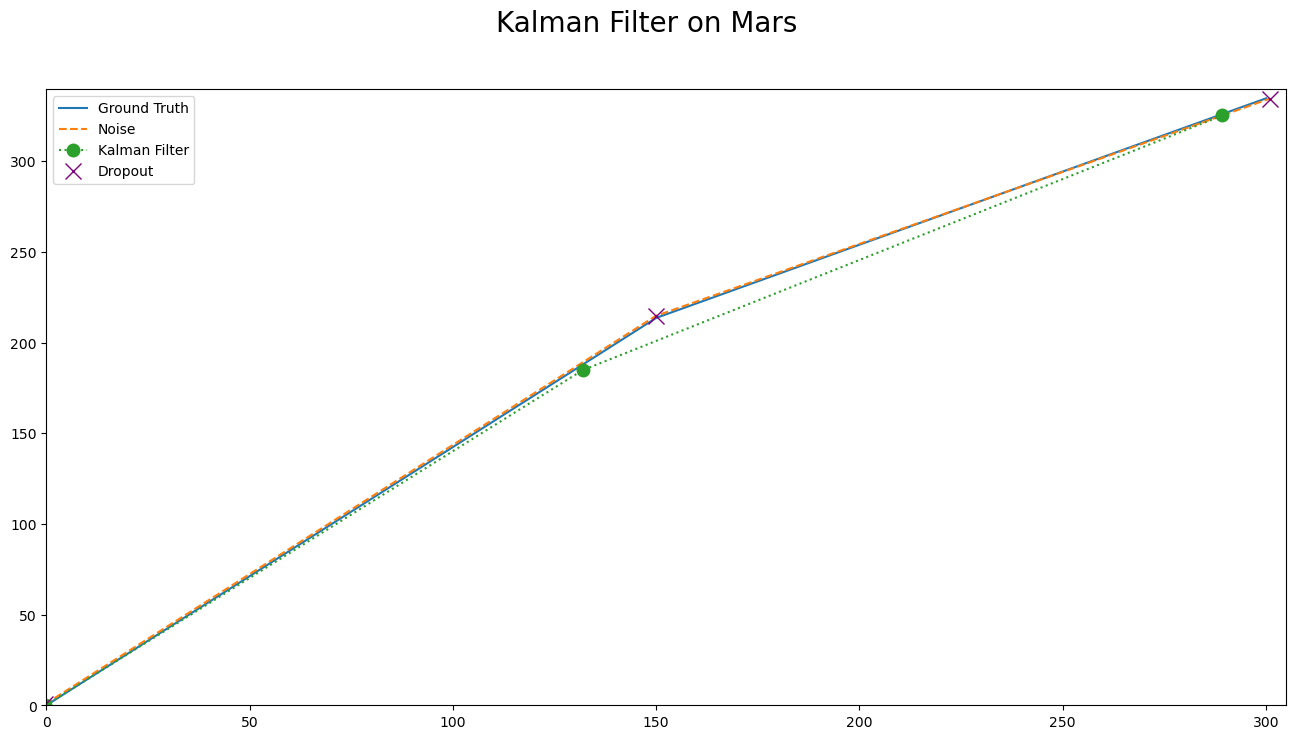

In [9]:
fig = plt.figure(figsize=(16,8))
fig.suptitle(f'Kalman Filter on {PLANET_CHOSEN}', fontsize=20)
plt.plot(q[0], q[1], ls = '-', markersize=7, label="Ground Truth")
plt.plot(q_noise[0], q_noise[1], ls = '--', markersize=11, label="Noise")
plt.plot(position[0], position[1], 'o',ls=":" , markersize=9, label="Kalman Filter")
plt.plot(q_dropout[0], q_dropout[1], 'x', markersize=11, color='purple', label="Dropout")
xmin = min(q[0])
xmax = max(q[0] + 5)
ymin = min(q[1])
ymax = max(q[1] + 5)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend()
plt.show()

### Particle Filter

* The task of your Particle Filter is to estimate the positions and velocity vectors of two balls flying simultaneously only from the observed erroneous positions over time. 
* Your implementation shall be flexible in the sense that it can handle variations similar to the ones from Task P2.1

#### Sources 
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb

In [10]:
import numpy as np
import scipy.stats as stats

In [11]:
# Gravity on the different planets and the moon
# Source is NASA

SUN = 275.0
MERCURY = 3.7
VENUS = 8.87
EARTH = 9.81
MOON = 1.6
MARS = 3.7
JUPITER = 23.1
SATURN = 9.0
URANUS = 8.7
NEPTUNE = 11.0
PLUTO = 0.7

In [795]:
mean_1_noise = [0,0]
cov_1_noise = np.eye(2)

mean_2_noise = [0,0]
cov_2_noise = np.eye(2)

DT = 0.1

V0_1 = 50
V0_2 = 50
Y0_1 = 0
Y0_2 = 20
ANGLE_1 = 45
ANGLE_2 = 45
DELTA_TIME = 5
G1 = EARTH
G2 = MARS


q_new_1, time = trajectory(v0=V0_1, y0=Y0_1, angle=ANGLE_1, dt=DT, delta_time=DELTA_TIME, g=G1) # launch speed, angle, height, _, _
q1 = q_new_1[[0,1]]
q_noise_1 = noise(q1, mean_1_noise, cov_1_noise)
q_dropout_1 = dropout(q=q_noise_1, t0=2, time_spent=1, dt=DT, error_val=-1000)


q_new_2, time = trajectory(v0=V0_2, y0=Y0_2, angle=ANGLE_2, dt=DT, delta_time=DELTA_TIME, g=G2)
q2 = q_new_2[[0,1]]
q_noise_2 = noise(q2, mean_2_noise, cov_2_noise)
q_dropout_2 = dropout(q=q_noise_2, t0=2, time_spent=1, dt=DT, error_val=-1000)


q_new = np.array([q_new_1, q_new_2])
q = q_new[:, [0,1]]
q_noise = np.array([q_noise_1, q_noise_2])
q_dropout = np.array([q_dropout_1, q_dropout_2])



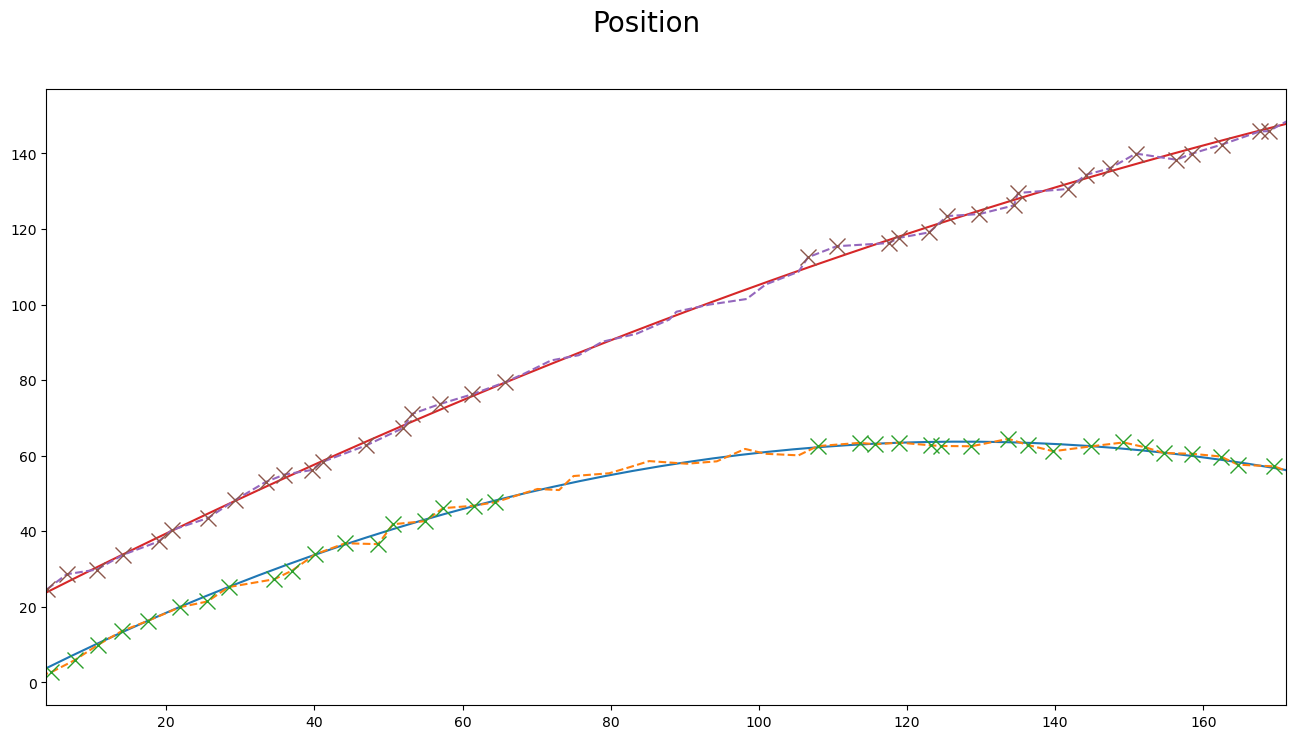

In [796]:
fig = plt.figure(figsize=(16,8))
fig.suptitle('Position', fontsize=20)

plt.plot(q[0][0], q[0][1], ls = '-', markersize=5)
plt.plot(q_noise[0][0], q_noise[0][1], ls = '--', markersize=5)
plt.plot(q_dropout[0][0], q_dropout[0][1], 'x', markersize=11)

plt.plot(q[1][0], q[1][1], ls = '-', markersize=5)
plt.plot(q_noise[1][0], q_noise[1][1],ls = '--', markersize=5)
plt.plot(q_dropout[1][0], q_dropout[1][1], 'x', markersize=11)

q_noise_combo_x = np.concatenate((q_noise[0][0], q_noise[1][0]))
q_noise_combo_y = np.concatenate((q_noise[0][1], q_noise[1][1]))

x_min = min(q_noise_combo_x + 5)
x_max = max(q_noise_combo_x - 5)
y_min = min(q_noise_combo_y - 5)
y_max = max(q_noise_combo_y + 5)

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.show()


In [15]:
def particles_initial_location(num_particles, y0_ball_1, v0_ball_1, y0_ball_2, v0_ball_2):
    '''
    Creating the starting point for the particles 
    num_particles = how many particles to start with
    y0_ball_1 = y position of ball 1
    v0_ball_1 = initla velocity of ball 1
    y0_ball_2 = y position of ball 2
    v0_ball_2 = initla velocity of ball 2
    '''
    particles = []
    

    for i in range(num_particles):
        ball_1_q = [y0_ball_1, v0_ball_1]
        ball_2_q = [y0_ball_2, v0_ball_2]
        
        particles.append([ball_1_q, ball_2_q])
    
    
    return np.array(particles)

In [16]:
def probability(ground_position, predicted_position, noise_std):
    noise_std = 1
    proba = stats.norm.pdf(ground_position, predicted_position, noise_std)
    proba = proba[0] * proba[1] 
    return proba

In [17]:
def predict_and_update(num_observations, num_particles, num_balls, ground_q, noise_q, particles):
    past_particles = []

    est_q = []

    for i_observation in range(num_observations):
        # Predict
        for i in range(num_particles):
            for i_ball in range(num_balls):
                new_position = (ground_q[i_ball][0][i_observation], ground_q[i_ball][1][i_observation])
                new_velocity = (ground_q[i_ball][2][i_observation], ground_q[i_ball][3][i_observation])
                particles[i][i_ball] = [new_position, new_velocity]

            
        particle_track = []
        # Update
        for i in range(num_particles):
            weights = 1.0
            for i_ball in range(num_balls):
                ground_position_x = ground_q[i_ball][0][i_observation]
                ground_position_y = ground_q[i_ball][1][i_observation]
                ground_position = np.array([ground_position_x, ground_position_y])

                noise_position_x = noise_q[i_ball][0][i_observation]
                noise_position_y = noise_q[i_ball][1][i_observation]
                noise_position = np.array([noise_position_x, noise_position_y])

                
                weights *= probability(ground_position, noise_position, noise_std=1)
            weights = weights

            particle_track.append([particles[i], weights])
        past_particles.append(particle_track)

        # Normalize weights
        weights /= np.sum(weights)

        # Resample
        index = np.random.choice(num_particles, size=num_particles, replace=True)
        particles = particles[index]
        weights = np.ones(num_particles) / num_particles

        # Estimate
        est_q_ = np.average(particles, weights=weights, axis=0)
        est_q = np.append(est_q, est_q_)
        # est_q.numpy.append(est_q)




    return np.array(est_q), np.array(past_particles)

In [20]:
def Particle_Filter(initial_particles, ground_q, noise_q, num_particles):
    # Initialization
    particles = initial_particles

    num_balls = 2
    weights = np.ones(num_particles) / num_particles

    num_observations = len(q[0][0])
    
    est_q, past_particles = predict_and_update(num_observations, num_particles, num_balls, ground_q, noise_q, particles)

    return np.array(est_q), np.array(past_particles)


In [792]:
num_particles = 100
pos0_1 = [0,0]
pos0_2 = [20,0]

v0_1 = [50, 50]
v0_2 = [70,70]

intial_particles_1= particles_initial_location(num_particles, pos0_1, v0_1, pos0_2, v0_2)

est_q, past_particles = Particle_Filter(intial_particles_1, q_new, q_noise, num_particles)

/var/folders/ny/y7fndwcs00j49fsj76zm9bgh0000gn/T/ipykernel_87913/4105932047.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(est_q), np.array(past_particles)


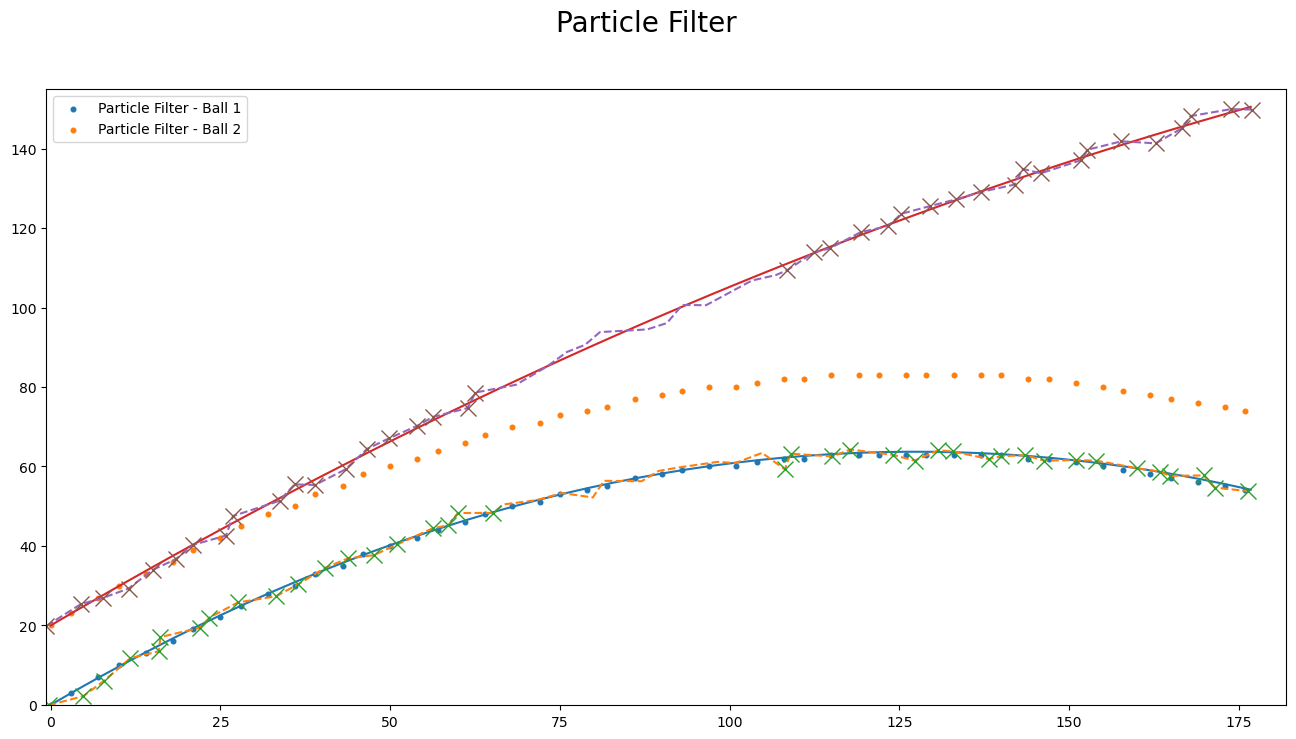

In [ ]:
x_est_1 = est_q[:, 0, 0, 0]
y_est_1 = est_q[:, 0, 0, 1]

x_est_2 = est_q[:, 1, 0, 0]
y_est_2 = est_q[:, 1, 0, 1]


fig = plt.figure(figsize=(16,8))
fig.suptitle('Particle Filter', fontsize=20)

plt.plot(q1[0], q1[1], ls = '-', markersize=5)
plt.plot(q_noise_1[0], q_noise_1[1], ls = '--', markersize=5)
plt.plot(q_dropout_1[0], q_dropout_1[1], 'x', markersize=11)

plt.plot(q2[0], q2[1], ls = '-', markersize=5)
plt.plot(q_noise_2[0], q_noise_2[1],ls = '--', markersize=5)
plt.plot(q_dropout_2[0], q_dropout_2[1], 'x', markersize=11)

plt.scatter(x_est_1,y_est_1,marker='o', s= 11,label = 'Particle Filter - Ball 1')
plt.scatter(x_est_2,y_est_2, marker= 'o',s= 11,label = 'Particle Filter - Ball 2')


x_min = min(q_noise_combo_x)
x_max = max(q_noise_combo_x + 5)
y_min = min(q_noise_combo_y)
y_max = max(q_noise_combo_y + 5)

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.legend()
plt.show()

